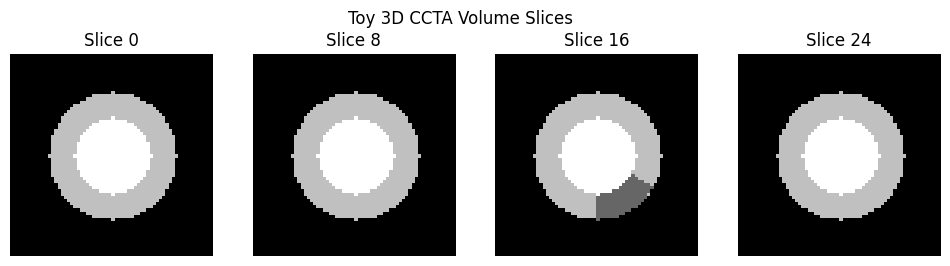

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def create_toy_ct_volume(depth=32, height=64, width=64, vessel_center=(32, 32),
                           vessel_radius=20, lumen_radius=12, plaque_slice=16):
    """
    Create a toy 3D volume (depth x height x width) representing a CCTA scan.
    - A cylindrical vessel is simulated in each slice.
    - The lumen is a circle of high intensity (200/255).
    - The vessel wall is a ring of moderate intensity (150/255).
    - In one specific slice (plaque_slice), part of the wall is replaced with a lower intensity (80/255) to simulate plaque.
    """
    volume = np.zeros((depth, height, width), dtype=np.uint8)
    for z in range(depth):
        # Create a blank 2D image for this slice
        slice_img = np.zeros((height, width), dtype=np.uint8)
        # Draw the vessel wall: circle with intensity 150
        cv2.circle(slice_img, vessel_center, vessel_radius, 150, -1)
        # Draw the lumen: circle with intensity 200
        cv2.circle(slice_img, vessel_center, lumen_radius, 200, -1)
        # For one slice, simulate plaque by modifying part of the wall
        if z == plaque_slice:
            # Create a mask for an elliptical segment of the wall
            mask = np.zeros_like(slice_img, dtype=np.uint8)
            cv2.ellipse(mask, vessel_center, (vessel_radius, vessel_radius),
                        0, 30, 90, 255, -1)
            slice_img[(mask == 255) & (slice_img == 150)] = 80
        volume[z] = slice_img
    return volume

toy_volume = create_toy_ct_volume()

# Visualize several slices from the volume
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, z in enumerate([0, 8, 16, 24]):
    axs[i].imshow(toy_volume[z], cmap='gray')
    axs[i].set_title(f"Slice {z}")
    axs[i].axis("off")
plt.suptitle("Toy 3D CCTA Volume Slices")
plt.show()


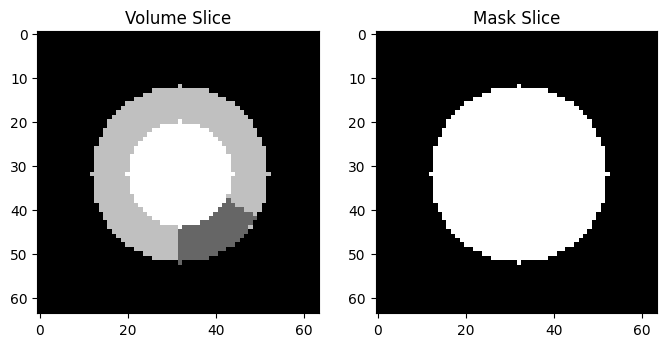

In [2]:
from torch.utils.data import Dataset, DataLoader

class ToyCT3DDataset(Dataset):
    def __init__(self, num_volumes=50, depth=32, height=64, width=64):
        self.num_volumes = num_volumes
        self.volumes = []
        self.masks = []
        for _ in range(num_volumes):
            vol = create_toy_ct_volume(depth, height, width)
            self.volumes.append(vol)
            self.masks.append(self.create_vessel_mask(vol))
            
    def create_vessel_mask(self, volume):
        # Simple threshold-based mask: consider pixels with intensity >= 70 as vessel (wall or lumen)
        mask = (volume >= 70).astype(np.float32)
        return mask

    def __len__(self):
        return self.num_volumes

    def __getitem__(self, idx):
        vol = self.volumes[idx].astype(np.float32) / 255.0  # normalize to [0,1]
        mask = self.masks[idx]
        # Add channel dimension (we treat the volume as a single channel 3D image)
        vol = np.expand_dims(vol, axis=0)   # shape: (1, depth, height, width)
        mask = np.expand_dims(mask, axis=0) # shape: (1, depth, height, width)
        return torch.tensor(vol), torch.tensor(mask)

dataset3d = ToyCT3DDataset(num_volumes=50)
dataloader3d = DataLoader(dataset3d, batch_size=2, shuffle=True)

# Visualize one central slice from one volume and its mask
vol, mask = dataset3d[0]
slice_idx = vol.shape[1] // 2
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(vol[0, slice_idx].numpy(), cmap='gray')
plt.title("Volume Slice")
plt.subplot(1,2,2)
plt.imshow(mask[0, slice_idx].numpy(), cmap='gray')
plt.title("Mask Slice")
plt.show()


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Simple3DSegNet(nn.Module):
    def __init__(self):
        super(Simple3DSegNet, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Conv3d(1, 8, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv3d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool3d(2, 2)
        
        # Decoder
        self.upconv1 = nn.ConvTranspose3d(16, 8, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv3d(8, 8, kernel_size=3, padding=1)
        self.dec_conv2 = nn.Conv3d(8, 1, kernel_size=1)  # output 1 channel for binary mask
        
    def forward(self, x):
        # Encoder path
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x_enc = self.pool(x)  # downsample
        
        # Decoder path
        x = F.relu(self.upconv1(x_enc))
        x = F.relu(self.dec_conv1(x))
        x = torch.sigmoid(self.dec_conv2(x))
        return x

model3d = Simple3DSegNet()
print(model3d)


Simple3DSegNet(
  (enc_conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (enc_conv2): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upconv1): ConvTranspose3d(16, 8, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  (dec_conv1): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (dec_conv2): Conv3d(8, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
)


In [4]:
import torch.optim as optim

criterion3d = nn.BCELoss()
optimizer3d = optim.Adam(model3d.parameters(), lr=0.001)
num_epochs = 5  # Increase epochs for better convergence in practice

model3d.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for volumes, masks in dataloader3d:
        optimizer3d.zero_grad()
        outputs = model3d(volumes)
        loss = criterion3d(outputs, masks)
        loss.backward()
        optimizer3d.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader3d):.4f}")
print("3D Segmentation Training Complete")


Epoch 1/5, Loss: 0.6432
Epoch 2/5, Loss: 0.4671
Epoch 3/5, Loss: 0.2355
Epoch 4/5, Loss: 0.0320
Epoch 5/5, Loss: 0.0085
3D Segmentation Training Complete


Generated 3 phases for the subject.
Phase quality scores: [np.float64(49.990452921737585), np.float64(49.988774283925125), np.float64(49.99698768422999)]
Selected phase indices: [2 0]
Centerline extracted.


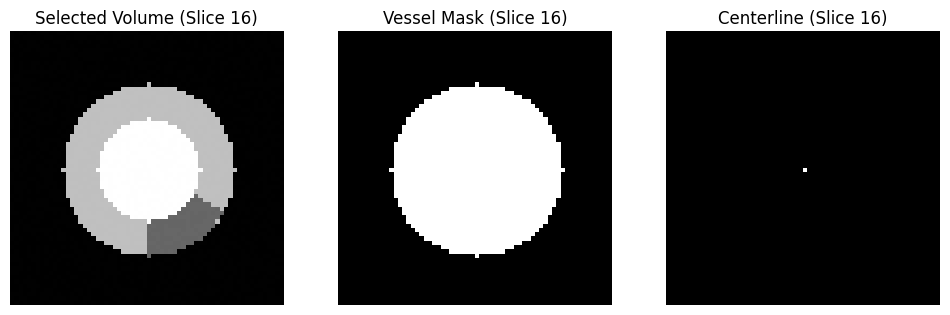

Lesion detected in slices: [16]
Lesion slice: 16
Estimated lumen diameter in lesion slice: 23.695962509005764
Estimated % Stenosis: 15.371562467836563
Plaque Quantification (voxel counts): {'low_attenuation': np.int64(143), 'non_calcified': np.int64(25969), 'calcified': np.int64(14112)}

--- Final Pipeline Report ---
lesion_slices: [16]
lesion_slice_used: 16
lumen_diameter_in_lesion: 23.695962509005764
stenosis_percent: 15.371562467836563
plaque_quantification: {'low_attenuation': np.int64(143), 'non_calcified': np.int64(25969), 'calcified': np.int64(14112)}


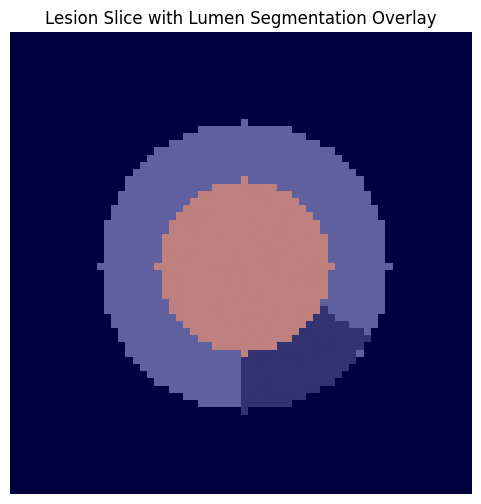

Simple3DSegNet(
  (enc_conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (enc_conv2): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upconv1): ConvTranspose3d(16, 8, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  (dec_conv1): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (dec_conv2): Conv3d(8, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
)
Epoch 1/5, Loss: 0.7305
Epoch 2/5, Loss: 0.3623
Epoch 3/5, Loss: 0.0262
Epoch 4/5, Loss: 0.0095
Epoch 5/5, Loss: 0.0068
3D Segmentation Training Complete
Centerline extracted from segmented mask.


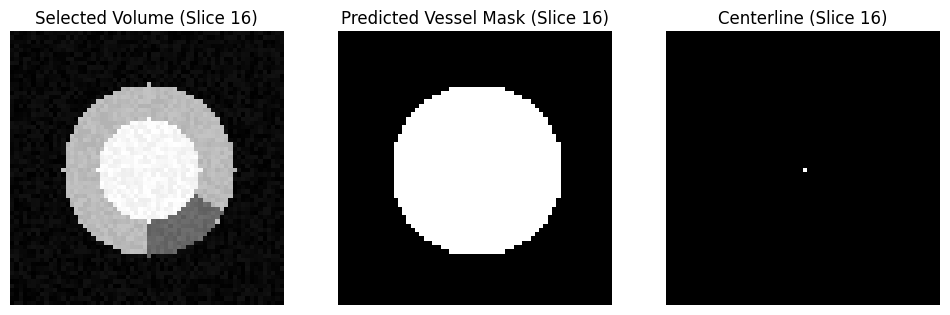

Lesion detected in slices: [16]
Lesion slice: 16
Estimated lumen diameter in lesion slice: 23.695962509005764
Estimated % Stenosis: 15.371562467836563
Plaque Quantification (voxel counts): {'low_attenuation': 142, 'non_calcified': 4807, 'calcified': 35153}

--- Final Pipeline Report ---
lesion_slices: [16]
lesion_slice_used: 16
lumen_diameter_in_lesion: 23.695962509005764
stenosis_percent: 15.371562467836563
plaque_quantification: {'low_attenuation': 142, 'non_calcified': 4807, 'calcified': 35153}


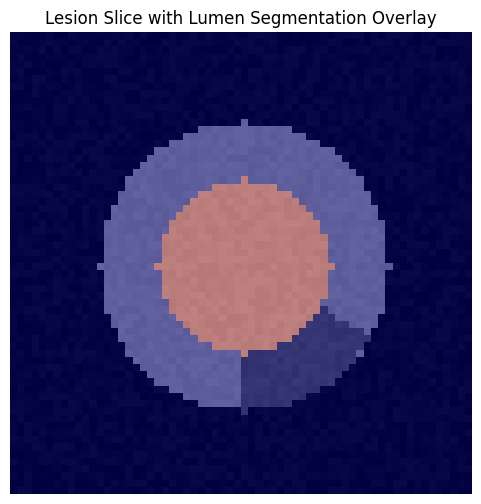

In [7]:
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
def skeletonize_3d(volume):
    """
    Simple workaround: apply 2D skeletonization slice-by-slice.
    This does not capture true 3D connectivity, but works as a toy example.
    """
    skel = np.zeros_like(volume, dtype=bool)
    for z in range(volume.shape[0]):
        skel[z] = skeletonize(volume[z].astype(bool))
    return skel

##############################################
# 1. Toy 3D Volume Generation & Multi-Phase Data
##############################################
def create_toy_ct_volume(depth=32, height=64, width=64, vessel_center=(32, 32),
                           vessel_radius=20, lumen_radius=12, plaque_slice=16, noise_level=0):
    """
    Create a toy 3D volume representing a CCTA scan.
      - Vessel wall: intensity 150.
      - Lumen: intensity 200.
      - On the designated plaque_slice, part of the wall is replaced with intensity 80 (plaque).
      - Optional noise is added.
    """
    volume = np.zeros((depth, height, width), dtype=np.uint8)
    for z in range(depth):
        slice_img = np.zeros((height, width), dtype=np.uint8)
        cv2.circle(slice_img, vessel_center, vessel_radius, 150, -1)  # vessel wall
        cv2.circle(slice_img, vessel_center, lumen_radius, 200, -1)    # lumen
        if z == plaque_slice:
            mask = np.zeros_like(slice_img, dtype=np.uint8)
            cv2.ellipse(mask, vessel_center, (vessel_radius, vessel_radius),
                        0, 30, 90, 255, -1)
            slice_img[(mask == 255) & (slice_img == 150)] = 80  # plaque region
        if noise_level > 0:
            noise = np.random.randint(0, noise_level, (height, width), dtype=np.uint8)
            slice_img = cv2.add(slice_img, noise)
        volume[z] = slice_img
    return volume

def create_multi_phase_volume(num_phases=3, **kwargs):
    """
    Create a list of volumes (phases) with minor variations (noise level).
    """
    phases = []
    for i in range(num_phases):
        noise_level = np.random.randint(0, 20)
        vol = create_toy_ct_volume(noise_level=noise_level, **kwargs)
        phases.append(vol)
    return phases

##############################################
# 2. PyTorch Dataset for 3D Volumes
##############################################
class ToyCT3DDataset(Dataset):
    def __init__(self, num_volumes=50, num_phases=3, depth=32, height=64, width=64):
        self.num_volumes = num_volumes
        self.num_phases = num_phases
        self.volumes = []  # List of lists: each element is a list of phases for one subject.
        self.masks = []    # Ground truth segmentation masks for the "best" phase.
        for _ in range(num_volumes):
            phases = create_multi_phase_volume(num_phases=num_phases, depth=depth, height=height, width=width, plaque_slice=16)
            # For training, we simulate a ground truth mask for the best phase.
            # Here, we simply choose the first phase as "best" and create a mask by thresholding.
            best_phase = phases[0]
            vol_mask = (best_phase >= 70).astype(np.float32)
            # Normalize volume intensities to [0,1]
            best_phase_norm = best_phase.astype(np.float32) / 255.0
            # For simplicity, we only use the best phase for training segmentation.
            self.volumes.append(best_phase_norm)  # shape: (depth, height, width)
            self.masks.append(vol_mask)             # binary mask

    def __len__(self):
        return self.num_volumes

    def __getitem__(self, idx):
        vol = self.volumes[idx]
        mask = self.masks[idx]
        # Add channel dimension: (C, D, H, W)
        vol = np.expand_dims(vol, axis=0)
        mask = np.expand_dims(mask, axis=0)
        return torch.tensor(vol, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

dataset3d = ToyCT3DDataset(num_volumes=50)
dataloader3d = DataLoader(dataset3d, batch_size=2, shuffle=True)

##############################################
# 3. Define a Simple 3D Segmentation Model (3D U-Net–Style)
##############################################
class Simple3DSegNet(nn.Module):
    def __init__(self):
        super(Simple3DSegNet, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Conv3d(1, 8, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv3d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool3d(2, 2)
        # Decoder
        self.upconv1 = nn.ConvTranspose3d(16, 8, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv3d(8, 8, kernel_size=3, padding=1)
        self.dec_conv2 = nn.Conv3d(8, 1, kernel_size=1)  # output 1 channel for binary mask

    def forward(self, x):
        # Encoder
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x_enc = self.pool(x)  # Downsample
        # Decoder
        x = F.relu(self.upconv1(x_enc))
        x = F.relu(self.dec_conv1(x))
        x = torch.sigmoid(self.dec_conv2(x))
        return x

model3d = Simple3DSegNet()
print(model3d)

##############################################
# 4. Training the 3D Segmentation Network
##############################################
criterion3d = nn.BCELoss()
optimizer3d = optim.Adam(model3d.parameters(), lr=0.001)
num_epochs = 5  # For toy example; increase for a real task.

model3d.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for volumes, masks in dataloader3d:
        optimizer3d.zero_grad()
        outputs = model3d(volumes)
        loss = criterion3d(outputs, masks)
        loss.backward()
        optimizer3d.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader3d):.4f}")
print("3D Segmentation Training Complete")

##############################################
# 5. Full Pipeline: Phase Selection, Segmentation, Centerline Extraction, Lesion Detection, Stenosis & Plaque Quantification
##############################################
# (a) Phase Selection Module:
def quality_metric(volume):
    """
    Compute a simple quality metric on a 3D volume.
    We average over all slices: mean difference between lumen (intensity > 0.7) and wall (intensity between 0.4 and 0.6).
    """
    lumen_mask = volume > 0.7
    wall_mask = (volume > 0.4) & (volume < 0.6)
    if np.sum(lumen_mask) == 0 or np.sum(wall_mask) == 0:
        return 0
    lumen_mean = np.mean(volume[lumen_mask])
    wall_mean = np.mean(volume[wall_mask])
    return lumen_mean - wall_mean

def select_best_phase(phases):
    phase_qualities = [quality_metric(vol.astype(np.float32)/255.0) for vol in phases]
    sorted_indices = np.argsort(phase_qualities)[::-1]
    return phases[sorted_indices[0]]  # return best phase

# For demonstration, we simulate a subject with multi-phase volumes.
subject_phases = create_multi_phase_volume(num_phases=3, depth=32, height=64, width=64, plaque_slice=16)
selected_volume = select_best_phase(np.array(subject_phases))
selected_volume_norm = selected_volume.astype(np.float32) / 255.0  # Normalize to [0,1]

# (b) 3D Segmentation using the trained model:
model3d.eval()
with torch.no_grad():
    input_vol = torch.tensor(np.expand_dims(selected_volume_norm, axis=0)[np.newaxis, ...], dtype=torch.float32)
    # Shape: (1, 1, depth, height, width)
    pred_mask = model3d(input_vol).squeeze().cpu().numpy()  # predicted vessel mask (values in [0,1])
    # Binarize prediction (threshold 0.5)
    vessel_mask_pred = (pred_mask > 0.5).astype(np.uint8)

# (c) Centerline Extraction:
centerline = skeletonize_3d(vessel_mask_pred)
print("Centerline extracted from segmented mask.")

# Visualize one mid-slice: original, predicted mask, centerline.
slice_idx = selected_volume.shape[0] // 2
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].imshow(selected_volume[slice_idx], cmap='gray')
axs[0].set_title(f"Selected Volume (Slice {slice_idx})")
axs[1].imshow(vessel_mask_pred[slice_idx], cmap='gray')
axs[1].set_title(f"Predicted Vessel Mask (Slice {slice_idx})")
axs[2].imshow(centerline[slice_idx], cmap='gray')
axs[2].set_title(f"Centerline (Slice {slice_idx})")
for ax in axs:
    ax.axis("off")
plt.show()

# (d) Lesion Detection & Stenosis Calculation:
def detect_lesion(volume, vessel_mask):
    """
    Detect lesion slices by identifying slices where vessel wall intensity drops (simulated plaque).
    Here, within the segmented vessel region, we check if any pixel has low intensity (<0.4).
    """
    lesion_slices = []
    for z in range(volume.shape[0]):
        candidate = (volume[z] < 0.4) & (vessel_mask[z] == 1)
        if np.sum(candidate) > 0:
            lesion_slices.append(z)
    return lesion_slices

lesion_slices = detect_lesion(selected_volume_norm, vessel_mask_pred)
print("Lesion detected in slices:", lesion_slices)

def compute_diameter(binary_mask):
    """
    Estimate diameter from binary mask area assuming a circular cross-section:
      diameter = 2 * sqrt(area / pi)
    """
    area = np.sum(binary_mask)
    diameter = 2 * np.sqrt(area / np.pi)
    return diameter

def segment_lumen(volume_slice):
    """
    For this toy example, assume the lumen has high intensity (normalized > 0.7).
    """
    return (volume_slice > 0.7).astype(np.uint8)

if lesion_slices:
    lesion_slice = lesion_slices[0]  # choose first lesion slice
    lumen_mask_lesion = segment_lumen(selected_volume_norm[lesion_slice])
    lumen_diameter = compute_diameter(lumen_mask_lesion)
    # For this toy example, use a fixed reference diameter (in pixels) from a normal slice.
    reference_diameter = 28  
    stenosis_percent = (1 - (lumen_diameter / reference_diameter)) * 100
    print("Lesion slice:", lesion_slice)
    print("Estimated lumen diameter in lesion slice:", lumen_diameter)
    print("Estimated % Stenosis:", stenosis_percent)
else:
    print("No lesion detected.")
    stenosis_percent = None

# (e) Plaque Quantification:
def quantify_plaque(volume, vessel_mask):
    """
    Quantify plaque within the vessel mask based on intensity thresholds.
    In this toy example (normalized):
      - Low-attenuation plaque: intensity < 0.4
      - Non-calcified plaque: intensity between 0.4 and 0.6
      - Calcified plaque: intensity >= 0.6
    Returns voxel counts in each category.
    """
    vessel_voxels = volume[vessel_mask == 1]
    low_att = np.sum(vessel_voxels < 0.4)
    non_calcified = np.sum((vessel_voxels >= 0.4) & (vessel_voxels < 0.6))
    calcified = np.sum(vessel_voxels >= 0.6)
    return {"low_attenuation": int(low_att), "non_calcified": int(non_calcified), "calcified": int(calcified)}

plaque_quant = quantify_plaque(selected_volume_norm, vessel_mask_pred)
print("Plaque Quantification (voxel counts):", plaque_quant)

# (f) Final Report Function:
def report_pipeline(volume, vessel_mask, centerline):
    lesion_slices = detect_lesion(volume, vessel_mask)
    if lesion_slices:
        lesion_slice = lesion_slices[0]
        lumen_mask_lesion = segment_lumen(volume[lesion_slice])
        lumen_diameter = compute_diameter(lumen_mask_lesion)
    else:
        lesion_slice = None
        lumen_diameter = None
    reference_diameter = 28  
    stenosis = None
    if lumen_diameter is not None:
        stenosis = (1 - (lumen_diameter / reference_diameter)) * 100
    plaque_info = quantify_plaque(volume, vessel_mask)
    report = {
        "lesion_slices": lesion_slices,
        "lesion_slice_used": lesion_slice,
        "lumen_diameter_in_lesion": lumen_diameter,
        "stenosis_percent": stenosis,
        "plaque_quantification": plaque_info
    }
    return report

pipeline_report = report_pipeline(selected_volume_norm, vessel_mask_pred, centerline)
print("\n--- Final Pipeline Report ---")
for key, value in pipeline_report.items():
    print(f"{key}: {value}")

# Visualize the selected lesion slice with a lumen segmentation overlay.
if lesion_slices:
    lesion_slice = lesion_slices[0]
    lumen_mask_lesion = segment_lumen(selected_volume_norm[lesion_slice])
    plt.figure(figsize=(6,6))
    plt.imshow(selected_volume[lesion_slice], cmap='gray')
    plt.imshow(lumen_mask_lesion, cmap='jet', alpha=0.5)
    plt.title("Lesion Slice with Lumen Segmentation Overlay")
    plt.axis("off")
    plt.show()
